<a href="https://colab.research.google.com/github/slvDev/Malaria-Detection-CNN-Keras/blob/master/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import zipfile
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
zip_ref_train = zipfile.ZipFile("/content/drive/My Drive/cell-images-for-detecting-malaria.zip", 'r')
zip_ref_train.extractall("/content")
zip_ref_train.close()

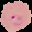

In [4]:
img_size = 32
dim = img_size, img_size
img = cv2.imread('/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
img = cv2.resize(img, (dim))
cv2_imshow(img)

In [12]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        #shear_range=0.25,
        #zoom_range=0.2,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.2,
        )

train_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        #color_mode='grayscale',
        class_mode='binary',
        subset='training',
        )

valid_generator = train_datagen.flow_from_directory(
        '/content/cell_images',  
        target_size=dim, 
        batch_size=32,
        #color_mode='grayscale',
        class_mode='binary',
        subset='validation',
        )

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1024, activation='relu'),    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
model.summary()

In [0]:
history = model.fit_generator(
        train_generator,
        epochs=15,
        validation_data=valid_generator,
        )

Epoch 1/15
689/689 [==============================] - 63s 91ms/step - loss: 0.3657 - acc: 0.8693 - val_loss: 0.2325 - val_acc: 0.9223
Epoch 2/15
689/689 [==============================] - 62s 89ms/step - loss: 0.1637 - acc: 0.9496 - val_loss: 0.2164 - val_acc: 0.9211
Epoch 3/15
689/689 [==============================] - 62s 89ms/step - loss: 0.1504 - acc: 0.9534 - val_loss: 0.1609 - val_acc: 0.9432
Epoch 4/15
689/689 [==============================] - 63s 91ms/step - loss: 0.1458 - acc: 0.9548 - val_loss: 0.1534 - val_acc: 0.9456
Epoch 5/15
689/689 [==============================] - 63s 91ms/step - loss: 0.1415 - acc: 0.9565 - val_loss: 0.1480 - val_acc: 0.9472
Epoch 6/15
689/689 [==============================] - 63s 91ms/step - loss: 0.1323 - acc: 0.9569 - val_loss: 0.6270 - val_acc: 0.5004
Epoch 7/15
689/689 [==============================] - 63s 91ms/step - loss: 0.1297 - acc: 0.9572 - val_loss: 0.1433 - val_acc: 0.9485
Epoch 8/15
689/689 [==============================] - 62s 90ms

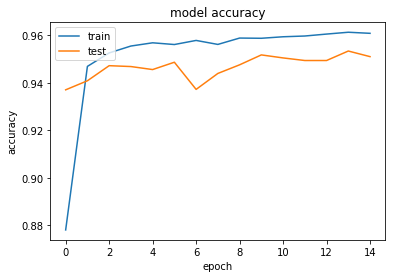

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

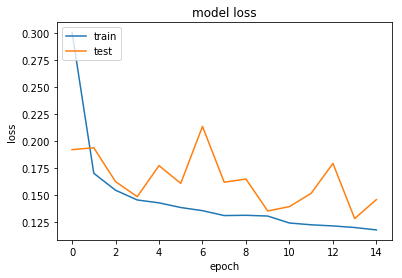

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()